In [1]:
import os
import netCDF4
import numpy as np
from matplotlib import pyplot as plt

# os.listdir()
file = "samples_2022.05.11.nc"
sinmod = netCDF4.Dataset(file)
timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])

u = np.array(sinmod['u_east'])
v = np.array(sinmod['v_north'])
we = np.array(sinmod['w_east'])
wn = np.array(sinmod['w_north'])
velocity = np.array(sinmod['w_velocity'])
salinity = np.array(sinmod['salinity'])

In [3]:
import os

folder_path = '/home/yasser.attia/Templates/inference'

file_names = os.listdir(folder_path)
print(file_names)

i=0
for file_name in file_names:
    if '.nc' in file_name:
        print(file_name)
        sinmod = netCDF4.Dataset(file_name)
        salinity = np.array(sinmod['salinity'])
        u = np.array(sinmod['u_east'])
        v = np.array(sinmod['v_north'])
        s0=salinity.shape[0]
        s1=salinity.shape[1]
        for idx1 in range(s0):
            for idx2 in range(s1):
                salinity[idx1,idx2,:,:]= np.clip(salinity[idx1,idx2,:,:],-10,30)

        for idx1 in range(s0):
            for idx2 in range(s1):
                u[idx1,idx2,:,:]= np.clip(u[idx1,idx2,:,:],-2,2)
        for idx1 in range(s0):
            for idx2 in range(s1):
                v[idx1,idx2,:,:]= np.clip(u[idx1,idx2,:,:],-2,2)
        if i==0:
            i=i+1
            Data_s=salinity[0:s0-1]
            Data_ss=salinity[1:s0]
            Data_u=u[0:s0-1]
            Data_v=v[0:s0-1]

        else:
            Data_s=np.concatenate((Data_s,salinity[0:s0-1]),axis=0)
            Data_ss=np.concatenate((Data_ss,salinity[1:s0]),axis=0)
            Data_u=np.concatenate((Data_u,u[0:s0-1]),axis=0)
            Data_v=np.concatenate((Data_v,v[0:s0-1]),axis=0)

        print(salinity.shape)



['project_5.ipynb', 'samples_2021.05.28.nc', 'project.ipynb', 'mnm.ipynb', 'samples_2021.05.29.nc', 'Data_v.npy', 'mm.ipynb', 'samples_2022.09.08.nc', 'samples_2022.06.22.nc', 'samples_2022.09.09.nc', 'samples_2022.06.21.nc', 'Outputs', 'Data_s.npy', 'Load_data.ipynb', 'project1.ipynb', 'Data_ss.npy', 'samples_2021.05.26.nc', 'samples_2021.05.27.nc', 'project_3.ipynb', 'Outputs_learning curve.png', 'SINMOD.ipynb', 'samples_2022.05.04.nc', 'Data_u.npy', 'project_2.ipynb', 'samples_2022.05.11.nc', 'samples_2022.05.10.nc', 'lstm_model.pth']
samples_2021.05.28.nc
(144, 25, 119, 149)
samples_2021.05.29.nc
(144, 25, 119, 149)
samples_2022.09.08.nc
(144, 25, 119, 149)
samples_2022.06.22.nc
(72, 25, 119, 149)
samples_2022.09.09.nc
(144, 25, 119, 149)
samples_2022.06.21.nc
(144, 25, 119, 149)
samples_2021.05.26.nc
(144, 25, 119, 149)
samples_2021.05.27.nc
(144, 25, 119, 149)
samples_2022.05.04.nc
(144, 25, 119, 149)
samples_2022.05.11.nc
(120, 25, 119, 149)
samples_2022.05.10.nc
(113, 25, 119, 

In [5]:
Data_s=Data_s.transpose(1, 0, 2, 3)
Data_ss=Data_ss.transpose(1, 0, 2, 3)
Data_u=Data_u.transpose(1, 0, 2, 3)
Data_v=Data_v.transpose(1, 0, 2, 3)


In [6]:
Data_s.shape

(25, 1446, 119, 149)

In [7]:
Data_s=Data_s.reshape(-1,1,119,149)
Data_ss=Data_ss.reshape(-1,1,119,149)
Data_u=Data_u.reshape(-1,1,119,149)
Data_v=Data_v.reshape(-1,1,119,149)


In [8]:
Data_s.shape

(36150, 1, 119, 149)

In [9]:
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
import torch
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_segments=torch.tensor(np.concatenate((Data_s,Data_u,Data_v),axis=1), dtype=torch.float).to(device)

In [ ]:
import gc 
del Data_s
del Data_u
del Data_v
gc.collect()

12

In [6]:
Data_ss = np.load('Data_ss.npy')

In [ ]:

all_labels = torch.tensor(Data_ss, dtype=torch.float)
combined_dataset = TensorDataset(all_segments, all_labels)


In [ ]:
del Data_ss
gc.collect()

11

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.bias = bias
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        
        self.conv = nn.Conv2d(in_channels=128,
                              out_channels=4 * hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))



class ConvLSTM(nn.Module):
    """
    A ConvLSTM network for generating image sequences.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        
        self.conv_lstm_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, bias)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_dim*3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )
    
    def forward(self, x, hidden_state=None):
        batch_size, seq_len, channels, height, width = x.size()
        if hidden_state is None:
            hidden_state = self.conv_lstm_cell.init_hidden(batch_size=batch_size, image_size=(height, width))
        
        h, c = hidden_state
        output_inner = []


        x1=x[:,:,0:1,:,:]
        x2=x[:,:,1:2,:,:]
        x3=x[:,:,2:3,:,:]

        x1_combined = x1.view(batch_size * seq_len, 1, height, width)
        
        encoded_x1 = self.encoder(x1_combined)
        
        x2_combined = x2.view(batch_size * seq_len, 1, height, width)
        
        encoded_x2 = self.encoder(x2_combined)

        x3_combined = x3.view(batch_size * seq_len, 1, height, width)
        
        encoded_x3 = self.encoder(x3_combined)

        for t in range(seq_len):
            xt1 = encoded_x1[t * batch_size:(t + 1) * batch_size, :, :, :]

            h1, c1 = self.conv_lstm_cell(xt1, (h, c))

            xt2 = encoded_x2[t * batch_size:(t + 1) * batch_size, :, :, :]

            h2, c2 = self.conv_lstm_cell(xt2, (h, c))
            xt3 = encoded_x2[t * batch_size:(t + 1) * batch_size, :, :, :]

            h3, c3 = self.conv_lstm_cell(xt3, (h, c))
            output_inner.append(h1)
        h = torch.cat((h1, h2, h3), dim=1)
        final_output = self.decoder(h)
        
        return final_output, (h1, c1)

In [11]:
all_segments=all_segments.unsqueeze(1)

In [12]:
all_segments.shape

torch.Size([36150, 1, 3, 119, 149])

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time_steps = 1
channels = 1
height = 119
width = 149
batch_size = 64
num_epochs = 20



num_samples = len(all_segments)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, num_samples))
dataset=TensorDataset(all_segments, all_labels)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = ConvLSTM(input_dim=channels, hidden_dim=64, kernel_size=(3, 3), num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        sequences, labels = data
        sequences = sequences.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs, _ = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.3f}')
            running_loss = 0.0

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data in val_loader:
            sequences, labels = data
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs, _ = model(sequences)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_loader):.3f}')

print('Finished Training')


In [ ]:
model.eval()
outs=[]
labs=[]
LOSS_tot=0
for i in range(sequences.shape[0]):
        seq=sequences[i:i+1,:,:,:,:]
        lab=labels[i:i+1,:,:,:]
        seq = seq.to(device)
        lab = lab.to(device)
        #outputs, _ = model(seq)
        
        if i==0:
                outputs, _ = model(seq)
        else:
                seq[:,:,0,:,:]=outputs
                outputs, _ = model(seq)
        loss = criterion(outputs, lab)
        outs.append(outputs)
        labs.append(lab)

        LOSS_tot+=loss.item()
        print(LOSS_tot/(i+1))


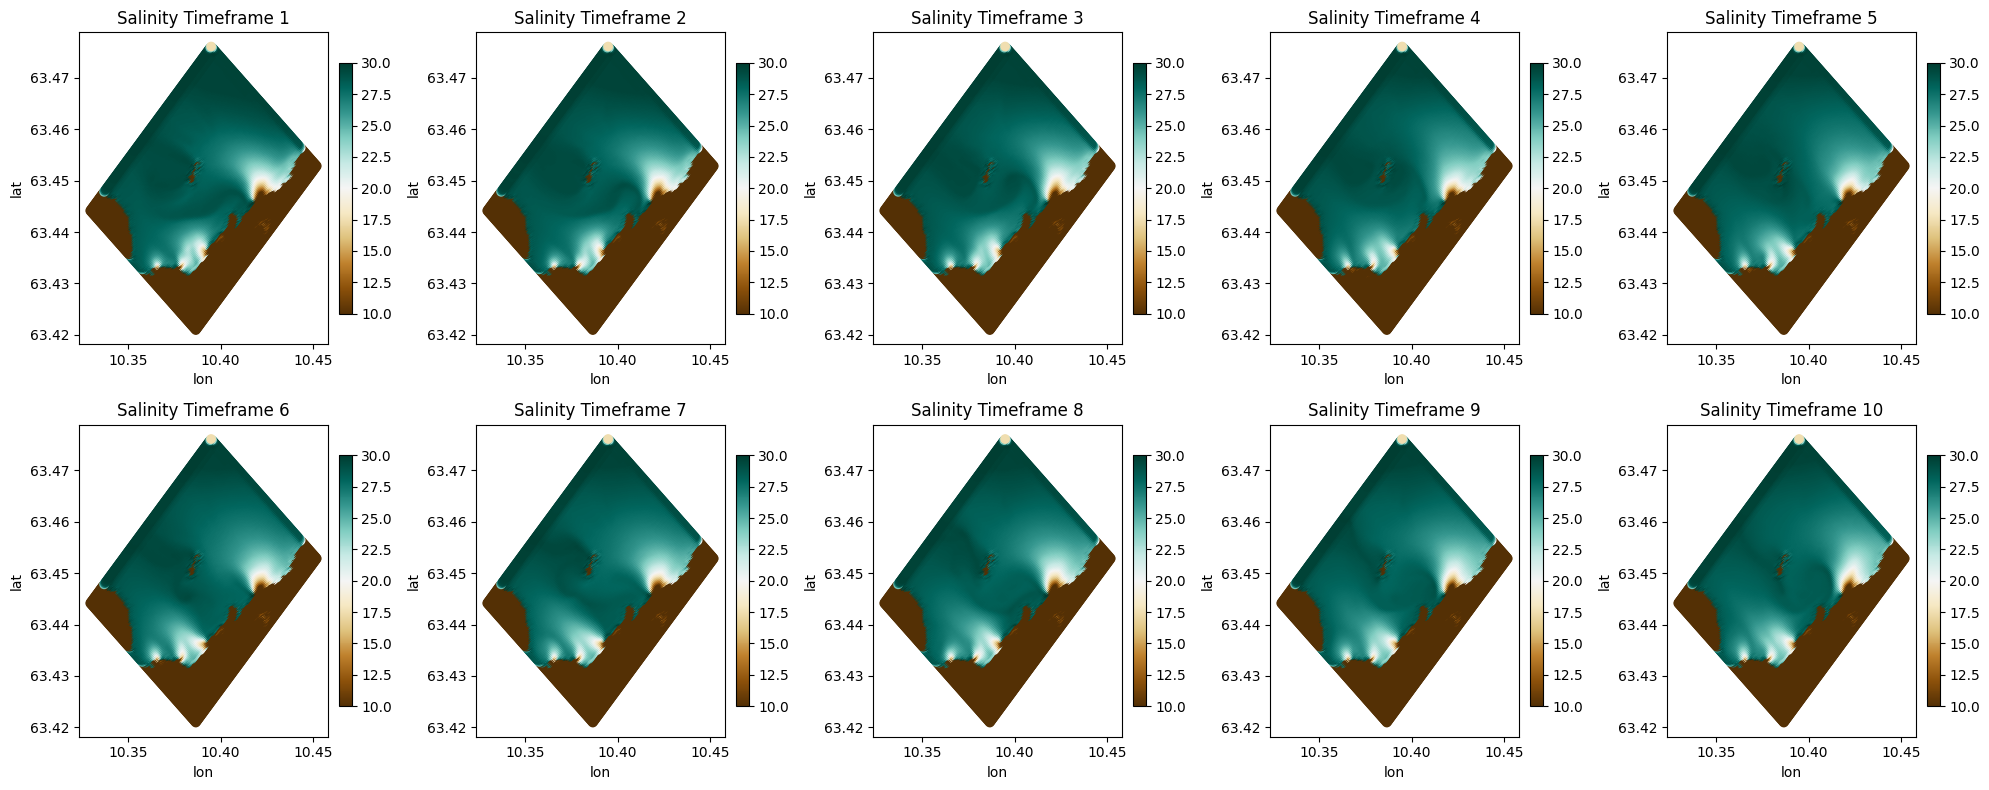

In [ ]:
import matplotlib.pyplot as plt



fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  
axes = axes.flatten()  


for i in range(10):
    sc = axes[i].scatter(lon, lat, c=outputs[10*i, 0, :, :].cpu().detach().numpy(), cmap="BrBG", vmin=10, vmax=30)
    axes[i].set_xlabel('lon')
    axes[i].set_ylabel('lat')
    axes[i].set_title(f'Salinity Timeframe {i+1}')

    # Adding a colorbar to each subplot, adjust the aspect to fit better
    plt.colorbar(sc, ax=axes[i], fraction=0.046, pad=0.04)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
